## Author: OMKAR ANANT BARE

In [ ]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/omkarbare/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/omkarbare/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/omkarbare/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/omkarbare/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
display(all_train_data)

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [ ]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # need to sort to ensure same initial order

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [ ]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


### Preprocessing using various techniques

In [ ]:
# preprocessing techniques to try for:
preprocessing_switches = {
        'convert_numbers'      : False,
        'separate_punctuation' : False, 
        'lowercase'            : False,
        'remove_punctuation'   : False,
        'apply_lemmatization'  : False,
        'remove_stopwords'     : False
    }

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

def pre_process(character_text):
    '''
    Function to apply following pre-processing techniques to all the concatenated lines of a character:
    
    - convert_numbers: convert any numbers to string 'NUMBER'
    - separate_punctuation:  separate punctuations at the end and the beginning
    - lowercase : lower-casing
    - remove_punctuation: removing any punctuations
    - apply_lemmatization: apply lemmatization technoque
    - remove_stopwords: removes common stop words in english language
    
    ::character_text:: a string with all of one character's lines
    '''
    
    # convert any numbers to string 'NUMBER'
    if preprocessing_switches['convert_numbers'] == True:
        character_text = re.sub('\d+', 'NUMBER', character_text)
     
    # simple tokenization on white space
    tokens = character_text.split()
        
    # separates punctuation at beginning and end of strings
    if preprocessing_switches['separate_punctuation'] == True:
        tokens = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", character_text) # separates punctuation at end of strings
        tokens = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", tokens) # separates punctuation at beginning of strings
        tokens = re.split(r"\s+", tokens)
    
    # normalisation - lower casing 
    if preprocessing_switches['lowercase'] == True:
        tokens = [t.lower() for t in tokens]
    
    # remove puctuations
    if preprocessing_switches['remove_punctuation'] == True:
        tokens = [word for word in tokens if word.isalpha()] #'isalpha()' method checks if string consists of alphabetic characters only
    
    # Lemmatizing sentence
    if preprocessing_switches['apply_lemmatization'] == True:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(words_sent) for words_sent in tokens]
    
    # Removing stop words
    processed_data = []
    if preprocessing_switches['remove_stopwords'] == True:
        stop_words = set(stopwords.words('english'))

        for t in tokens:
            if t not in stop_words:
                processed_data.append(t)
        return processed_data
    
    return tokens

In [ ]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name in zip(df.Line, df.Character_name):
        
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
            
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
        
    return character_docs

In [ ]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("\nTotal words:", total_words)

Num. Characters:  16 

SHIRLEY Number of Words:  3848
OTHER Number of Words:  3244
JACK Number of Words:  4435
RONNIE Number of Words:  3442
TANYA Number of Words:  3786
SEAN Number of Words:  3637
ROXY Number of Words:  3838
HEATHER Number of Words:  4098
MAX Number of Words:  4363
IAN Number of Words:  4332
JANE Number of Words:  3648
STACEY Number of Words:  3913
PHIL Number of Words:  3635
MINTY Number of Words:  4005
CHRISTIAN Number of Words:  3738
CLARE Number of Words:  4344

Total words: 62306


In [ ]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")

Num. Characters:  16 



In [ ]:
def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    return counts 

In [ ]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

In [ ]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  / (norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [ ]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels, display=False):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    
    if display == True:
        print("mean rank", np.mean(rankings))
        print("mean cosine similarity", mean_cosine_similarity)
        print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy)
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [ ]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [ ]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the validation data - only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)

# print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("\ntotal words:", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

TANYA Num of Words:  438
MAX Num of Words:  737
SEAN Num of Words:  366
SHIRLEY Num of Words:  329
OTHER Num of Words:  357
STACEY Num of Words:  412
RONNIE Num of Words:  464
JACK Num of Words:  351
PHIL Num of Words:  475
IAN Num of Words:  508
JANE Num of Words:  458
ROXY Num of Words:  392
HEATHER Num of Words:  411
MINTY Num of Words:  470
CHRISTIAN Num of Words:  489
CLARE Num of Words:  405

total words: 7062


In [ ]:
print('Result for tokenization on white space only:')
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, 
                                                                          val_feature_matrix, 
                                                                          train_labels, 
                                                                          val_labels, 
                                                                          display = True) #set display = True to print results  

Result for tokenization on white space only:
mean rank 4.5
mean cosine similarity 0.9128136458100018
4 correct out of 16 / accuracy: 0.25


In [ ]:
# reset all to false to search for finding best combination
preprocessing_switches = {k: False for k in preprocessing_switches.keys()}

In [ ]:
# create all possible combinations of pre-processing techniques
from itertools import chain, combinations  # for powerset function, to get all combinations

def powerset(iterable):
    '''
    function to create all possible combinations.
    '''
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

combos = [list(p) for p in powerset(preprocessing_switches.keys())]

# make all possible combinations of switches
for switches in combos:
    preprocessing_switches = {k : False for k in preprocessing_switches.keys()}
    for switch in switches:
        preprocessing_switches[switch] = True
#     print('--'* 58)
#     display(preprocessing_switches)

In [ ]:
ppss = []
mean_ranks = []
mean_cosine_simliarities = []
accs = []
dfs = []

for switches in combos:
    preprocessing_switches = {k : False for k in preprocessing_switches.keys()}
    for switch in switches:
        preprocessing_switches[switch] = True
        ppss.append(preprocessing_switches)
    
        # pre-processing for each combination
        training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
        train_labels = [name for name, doc in training_corpus]

        training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)


        total_words = 0
        for name in val_character_docs.keys():
            total_words += len(val_character_docs[name].split())

        # create list of pairs of (character name, pre-processed character) 
        val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
        val_labels = [name for name, doc in val_corpus]

        # Just transform the val_feature_matrix, don't fit
        val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

        # store results for each combination
        mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, 
                                                                                  val_feature_matrix, 
                                                                                  train_labels, 
                                                                                  val_labels)
        mean_ranks.append(mean_rank)
        mean_cosine_simliarities.append(mean_cosine_simliarity)
        accs.append(acc)
        dfs.append(df)

In [ ]:
results_df = pd.DataFrame(ppss)
results_df['mean_rank'] = pd.Series(mean_ranks)
results_df['mean_cosine_simliarity'] = pd.Series(mean_cosine_simliarities)
results_df['accuracy'] = pd.Series(accs)

In [ ]:
# sort by 'mean_rank'
results_df = results_df.sort_values(by=['mean_rank'])

In [ ]:
display(results_df.head(10))

,convert_numbers,separate_punctuation,lowercase,remove_punctuation,apply_lemmatization,remove_stopwords,mean_rank,mean_cosine_simliarity,accuracy
151,False,True,False,True,True,True,1.3750,0.807745,0.8125
115,True,True,False,True,False,True,1.3750,0.806145,0.8750
175,True,True,False,True,True,True,1.3750,0.807702,0.8125
80,False,True,False,True,False,True,1.4375,0.806190,0.8125
191,True,True,True,True,True,True,2.0625,0.564121,0.6250
185,False,True,True,True,True,True,2.0625,0.564238,0.6250
143,False,True,True,True,False,True,2.3125,0.536360,0.6250
165,True,True,True,True,False,True,2.3125,0.536273,0.6250
150,False,True,False,True,True,True,2.6875,0.862782,0.5000
149,False,True,False,True,True,True,2.6875,0.860956,0.5000


In [ ]:
# to find which feature being true tends to help more
for key in preprocessing_switches.keys():
    print(key,':', sum(results_df[results_df[key]==True]['mean_rank']) / len(results_df[results_df[key]==True]))

convert_numbers : 4.01171875
separate_punctuation : 3.5089285714285716
lowercase : 4.068638392857143
remove_punctuation : 3.834263392857143
apply_lemmatization : 3.939174107142857
remove_stopwords : 3.8504464285714284


In [ ]:
# best possible combination of preprocessing switches
preprocessing_switches = {
        'convert_numbers'      : False,
        'separate_punctuation' : True, 
        'lowercase'            : False,
        'remove_punctuation'   : True,
        'apply_lemmatization'  : True,
        'remove_stopwords'     : True
    }

In [ ]:
# get the training data - only 360 lines used for each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the validation data - only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("\nTotal words:", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

print('\nResults on validation set:')
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, 
                                                                          val_feature_matrix, 
                                                                          train_labels, 
                                                                          val_labels, 
                                                                          display=True) # set display = True to print results  

Num. Characters:  16 

TANYA Num of Words:  438
MAX Num of Words:  737
SEAN Num of Words:  366
SHIRLEY Num of Words:  329
OTHER Num of Words:  357
STACEY Num of Words:  412
RONNIE Num of Words:  464
JACK Num of Words:  351
PHIL Num of Words:  475
IAN Num of Words:  508
JANE Num of Words:  458
ROXY Num of Words:  392
HEATHER Num of Words:  411
MINTY Num of Words:  470
CHRISTIAN Num of Words:  489
CLARE Num of Words:  405

Total words: 7062

Results on validation set:
mean rank 1.375
mean cosine similarity 0.807745233713113
13 correct out of 16 / accuracy: 0.8125


In [ ]:
def pos_tagging(tokens):
    tagged_words = nltk.pos_tag(tokens)
    pos_tagged_sentence = [word + "-" + tag for word, tag in tagged_words]
    return pos_tagged_sentence

In [ ]:
# base settings
_WEIGHT_ = "binary"  
_N_ = 1 

In [ ]:
def to_feature_vector_dictionary(character_doc, extra_features):
    '''
    function to perform:
    - pos tagging
    - extract different ngram sequences from tokens 
    - add different weightings to extracted ngrams
    '''
    
    feature_vector_dict =  Counter()  
    
    # collect the counts for all n in range (1, N)
    for n in range(1, _N_+1):
        tokens = ["<s>"]*(n-1) + character_doc + ["</s>"]
        
        # perform pos tagging
        new_tokens = pos_tagging(tokens)
            
        for i in range(n-1, len(new_tokens)):
            raw_ngram = " ".join(new_tokens[i-(n-1):i+1])
            n_gram = "{}@{}".format(n, raw_ngram)     
            feature_vector_dict[n_gram]+=1
        
    # binary counts (1 if present)
    if _WEIGHT_ == "binary":
        feature_vector_dict = {x:1 for x in feature_vector_dict.keys()}
        
    # number of counts
    if _WEIGHT_ == "counts":
        counts = Counter(character_doc)  
        feature_vector_dict = dict(counts)   
        
    # bag-of-words counts
    elif _WEIGHT_ == "weighted": 
        feature_vector_dict = {x:feature_vector_dict[x]/(len(character_doc)+1) for x in feature_vector_dict.keys()}
            
    return feature_vector_dict

In [ ]:
# to check 'to_feature_vector_dictionary' function working properly
_N_ = 2
_WEIGHT_ = "weighted"
to_feature_vector_dictionary(['This', 'is', 'is', 'an', 'example', 'sentence'], [])

{'1@This-DT': 0.14285714285714285,
 '1@is-VBZ': 0.2857142857142857,
 '1@an-DT': 0.14285714285714285,
 '1@example-NN': 0.14285714285714285,
 '1@sentence-NN': 0.14285714285714285,
 '1@</s>-NN': 0.14285714285714285,
 '2@<s>-NN This-DT': 0.14285714285714285,
 '2@This-DT is-VBZ': 0.14285714285714285,
 '2@is-VBZ is-VBZ': 0.14285714285714285,
 '2@is-VBZ an-DT': 0.14285714285714285,
 '2@an-DT example-NN': 0.14285714285714285,
 '2@example-NN sentence-NN': 0.14285714285714285,
 '2@sentence-NN </s>-NN': 0.14285714285714285}

In [ ]:
# try different settings
count_weights = ["binary", "counts", "weighted"]
ngram_feature_range = range(1,4)

In [ ]:
n_sizeFT = []
weightsFT = []
mean_ranksFT = []
mean_cosine_simliaritiesFT = []
accsFT = []
dfsFT = []
for w in count_weights:
        for n in ngram_feature_range:
            weightsFT.append(w)
            n_sizeFT.append(n)
            _N_ = n
            _WEIGHT_ = w
            training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)
            val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)
            mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, 
                                                                                      val_feature_matrix, 
                                                                                      train_labels, 
                                                                                      val_labels, display=False)
            mean_ranksFT.append(mean_rank)
            mean_cosine_simliaritiesFT.append(mean_cosine_simliarity)
            accsFT.append(acc)
            dfsFT.append(df)

In [ ]:
results_FT = pd.DataFrame(weightsFT,columns=['weights'])
results_FT['ngrams'] = pd.Series(n_sizeFT)
results_FT['mean_rank'] = pd.Series(mean_ranksFT)
results_FT['mean_cosine_simliarity'] = pd.Series(mean_cosine_simliaritiesFT)
results_FT['accuracy'] = pd.Series(accsFT)

In [ ]:
# sort by 'mean_rank'
results_FT = results_FT.sort_values(by=['mean_rank'])
display(results_FT)

,weights,ngrams,mean_rank,mean_cosine_simliarity,accuracy
3,counts,1,1.3750,0.807745,0.8125
4,counts,2,1.3750,0.807745,0.8125
5,counts,3,1.3750,0.807745,0.8125
6,weighted,1,1.7500,0.804615,0.7500
7,weighted,2,2.2500,0.753480,0.7500
1,binary,2,2.3125,0.153544,0.5625
2,binary,3,2.4375,0.117183,0.5000
0,binary,1,2.8125,0.256563,0.5000
8,weighted,3,3.1250,0.732505,0.6250


In [ ]:
# to find which ngram range gives best accuracy on average
for n in range(1,4):
    print(n, sum(results_FT[results_FT["ngrams"]==n]['accuracy']) / len(results_FT[results_FT["ngrams"]==n]))

1 0.6875
2 0.7083333333333334
3 0.6458333333333334


In [ ]:
# to find which weighting gives best accuracy
for w in count_weights:
    print(w, sum(results_FT[results_FT['weights']==w]['accuracy']) / len(results_FT[results_FT['weights']==w]))

binary 0.5208333333333334
counts 0.8125
weighted 0.7083333333333334


- **n-gram range of (1,2)** setting gave best accuracy on average
- **counts** weighting gave best accuracy on average

### results after testing different n-grams and weightings

In [ ]:
# best setting
_WEIGHT_ = "counts"  
_N_ = 2

In [ ]:
# best possible combination of preprocessing switches
preprocessing_switches = {
        'convert_numbers'      : False,
        'separate_punctuation' : True, 
        'lowercase'            : False,
        'remove_punctuation'   : True,
        'apply_lemmatization'  : True,
        'remove_stopwords'     : True
    }

In [ ]:
# get the training data - only 360 lines used for each character

train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the validation data - only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("\nTotal words:", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

print('\nResults on validation set:')
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, 
                                                                          val_feature_matrix, 
                                                                          train_labels, 
                                                                          val_labels, 
                                                                          display=True) # set display = True to print results  

Num. Characters:  16 

TANYA Num of Words:  438
MAX Num of Words:  737
SEAN Num of Words:  366
SHIRLEY Num of Words:  329
OTHER Num of Words:  357
STACEY Num of Words:  412
RONNIE Num of Words:  464
JACK Num of Words:  351
PHIL Num of Words:  475
IAN Num of Words:  508
JANE Num of Words:  458
ROXY Num of Words:  392
HEATHER Num of Words:  411
MINTY Num of Words:  470
CHRISTIAN Num of Words:  489
CLARE Num of Words:  405

Total words: 7062

Results on validation set:
mean rank 1.375
mean cosine similarity 0.807745233713113
13 correct out of 16 / accuracy: 0.8125


### Analysis of similarity results

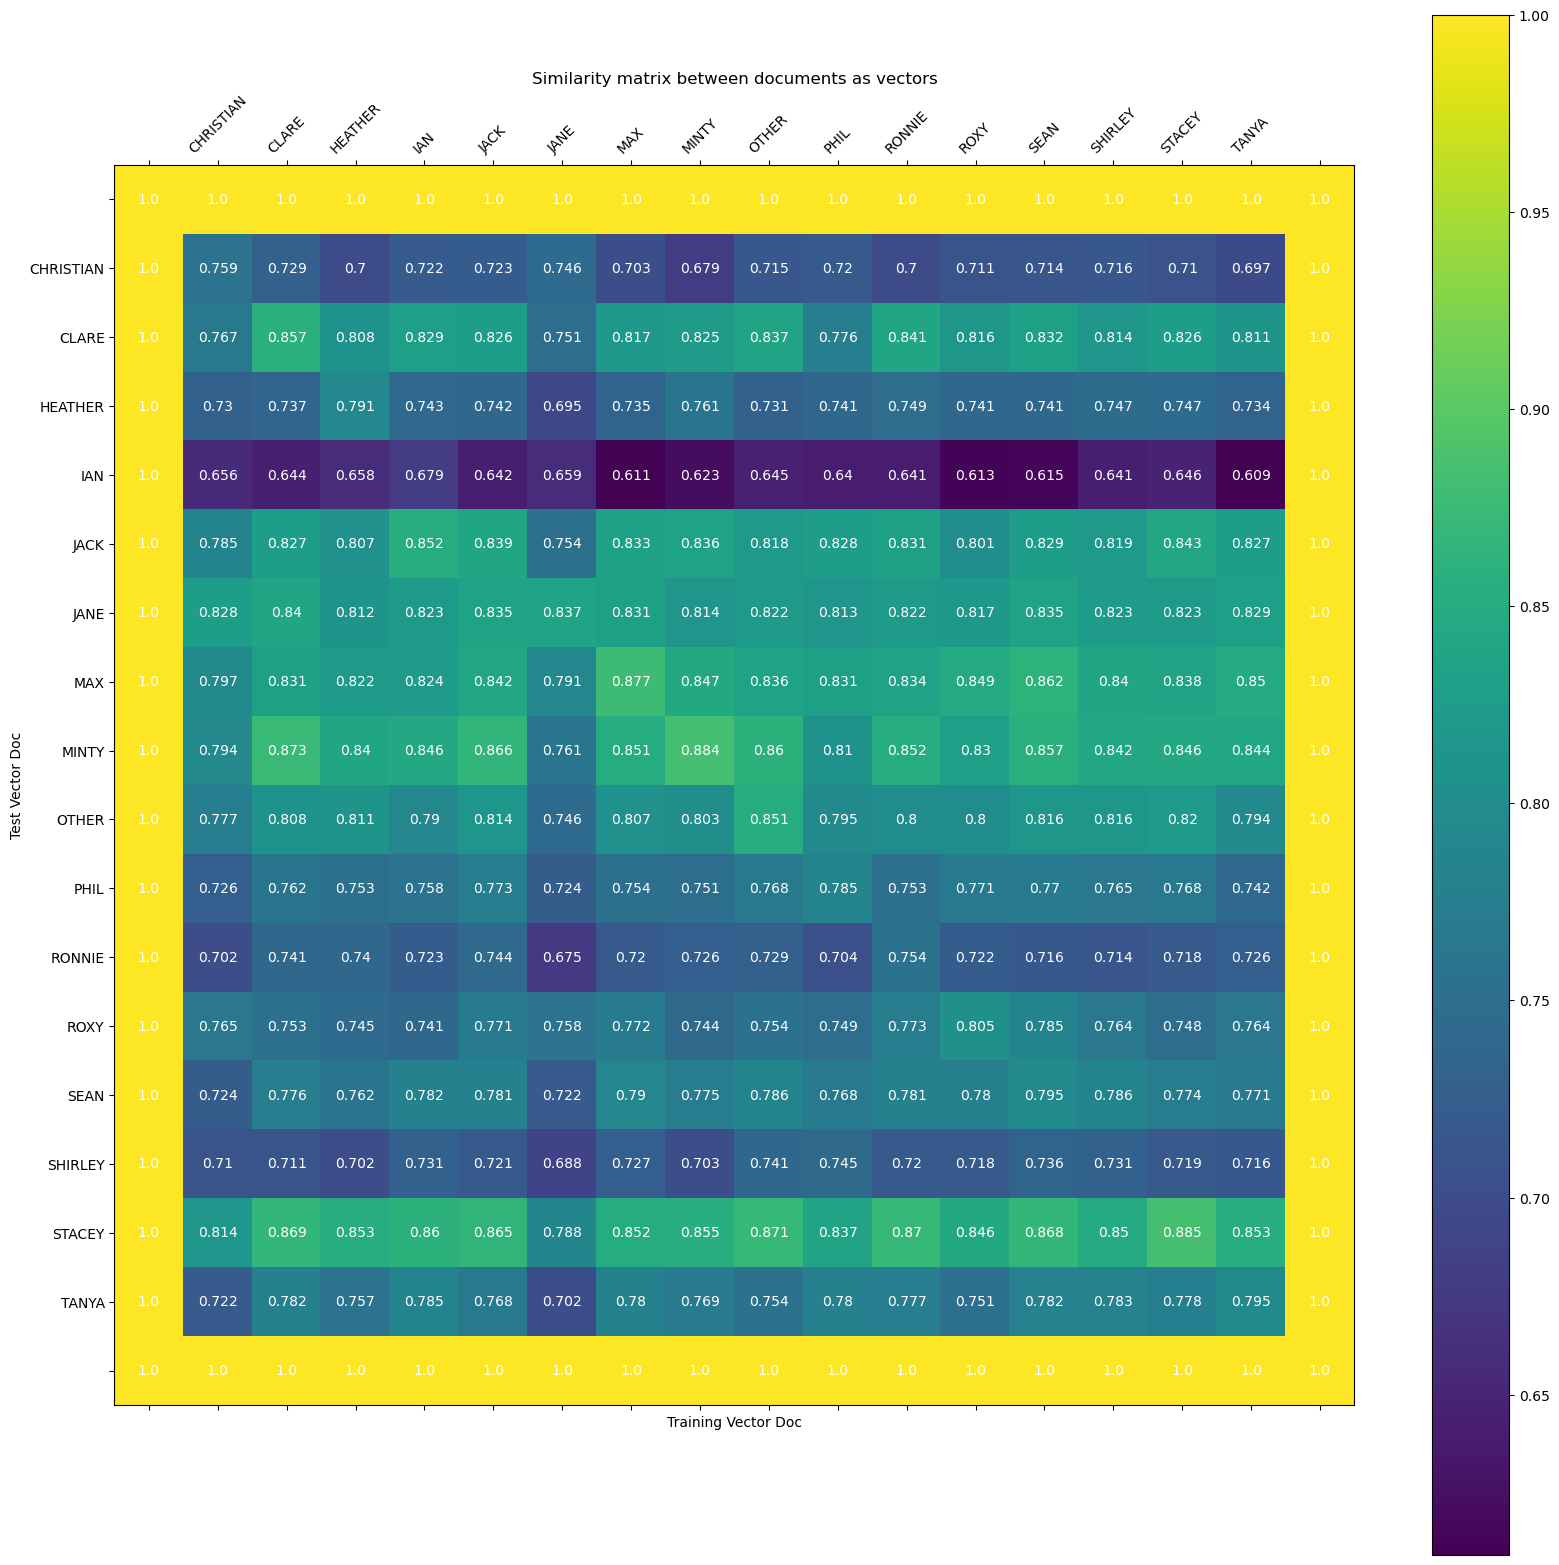

In [ ]:
plot_heat_map_similarity(df)

### Case where heldout character vector ranked closest to each character's training vector which are not the character themselves:

- CLARE
- JACK
- JANE
- MAX
- MINTY
- STACEY

In [ ]:
train_character_docs['CLARE']

"Dot? Dot! _EOL_ Where's Dot? _EOL_ Do people still use this place? _EOL_ And what about Pauline? _EOL_ Something like that. _EOL_ I didn't. _EOL_ I'm waiting for someone. _EOL_ The fella that runs this place. Does he still live round here? _EOL_ Bit of a comedown from the one I remember. _EOL_ Bacon sandwich. Please. _EOL_ Not really. _EOL_ Listen...er... _EOL_ I don't suppose you could lend me some cash can ya? Just to get me out of here. _EOL_ Pauline... _EOL_ Come on, Ian. You chucked me and Sonia out the cafe enough times. _EOL_ Not so little. _EOL_ I tried to call for Dot, but she wasn't there. My boyfriend. My ex-boyfriend. _EOL_ All I need is somewhere to clean myself up and then I'm out of here. Please, Ian. I've got nowhere else to go... _EOL_ I mean it... As soon as I've got the cash, I'm on the next train out of here... _EOL_ Look I've gotta go...Sorry I hope you don't mind... _EOL_ Are you alright, Ian? _EOL_ It's just you seem a bit flustered. Is this Pauline's old stuff?

In [ ]:
val_character_docs['MINTY']

"So how was it left? _EOL_ Well he might not be a United fan. Might be a City fan. Might be neither. _EOL_ You know what you should do? Go round and offer to fix her shoes. _EOL_ Prince Charming. _EOL_ So what are you waiting for? _EOL_ Good man. _EOL_ Gal, Gal. You're still in with a chance, son. I just spoke to Mickey. _EOL_ he didn't stay there last night, Jase. He just went round there this morning _EOL_ Mickey told me! _EOL_ Was he wearing the same clothes as he was wearing yesterday when you see him this morning? _EOL_ Well what are you waiting for, son! _EOL_ Go on then. _EOL_ As in country and western? _EOL_ I am not wearing a cowboy hat. _EOL_ Why can't I just wear a suit like normal people, please? _EOL_ No, Gal. It's me. It's me mate. What've I got to offer her, eh? I mean look at me. All my best years are behind me mate, and none of them were much cop. _EOL_ I'm past it. I've got sod all money in the bank, I should be retiring in a few years, only I can't afford to do that.

### Case where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set

In [ ]:
train_character_docs['IAN']

"Perhaps I should cook them something. Like I did for Martin when Auntie Pauline, you know... _EOL_ Something like this, on a holiday...New Year'll never be the same, will it? Not for them. _EOL_ Plus they were going to be moving in today. _EOL_ Maybe they'll do it later this week. Less to _EOL_ An apology. _EOL_ What happened to Kevin...made me realise that I shouldn't, you know, take stuff for granted. _EOL_ You. I know you've found this Christmas tough. I didn't have to make it tougher. So... _EOL_ The kids are _EOL_ What...? _EOL_ Jane... _EOL_ Sorry? _EOL_ Here she is, the face that fried a thousand chips... Can you believe that Ronnie Mitchell? Steals the catering for Kevin's funeral, then comes in to borrow an egg-slicer. I mean, what sort of caterer doesn't have basic equipment? Me and you, we've got to put that buffet through its paces later, probe for weaknesses - _EOL_ Is this about Steven? _EOL_ You see? And people say I don't understand women. _EOL_ How is everyone? _EOL_ 

In [ ]:
val_character_docs['IAN']

"That was delicious. Where d'you learn to cook like that? _EOL_ Simon didn't cook then? _EOL_ Six or seven? Living with _EOL_ Still, a bit irresponsible, isn't it? When you've got a child in the house? _EOL_ It was like having a herd of elephants over my head last night. _EOL_ No. Bobby'll have to go in with you. _EOL_ Don't argue alright? It ain't negotiable. _EOL_ Right. Better get to the cash and carry. _EOL_ We're almost out of salt. _EOL_ There you go. Sorted. Salted, get it? _EOL_ No, you stand there. Here you go in front ‚cos you're the littlest. _EOL_ It's a big deal for me Jane. I want it to be right. Lucy hurry up. Trust you to oversleep. _EOL_ Here. _EOL_ I've got all my family together at last. Beale and Co. Come on, smile. _EOL_ No it won't. _EOL_ Peter. It's me. Just so you know. I'll be taking your training today as usual. _EOL_ After the way she spoke to me? I don't think so. _EOL_ I made the offer, didn't I? _EOL_ No I was just wondering - _EOL_ Wondering how long it m